In [ ]:
import sqlite3
import csv

# Define file paths
file_path = 'output_data.csv'
new_db_path = 'normalized_data.db'

# Create a new SQLite database connection
conn = sqlite3.connect(new_db_path)
cursor = conn.cursor()

# Create tables for normalization
cursor.execute("""
CREATE TABLE IF NOT EXISTS MainTable (
    ID INTEGER PRIMARY KEY,
    Age INTEGER,
    AnnualIncome INTEGER,
    FamilyMembers INTEGER,
    ChronicDiseases INTEGER,
    TravelInsurance INTEGER,
    EmploymentTypeID INTEGER,
    GraduateStatusID INTEGER,
    FrequentFlyerID INTEGER,
    TravelAbroadID INTEGER,
    FOREIGN KEY (EmploymentTypeID) REFERENCES EmploymentType(ID),
    FOREIGN KEY (GraduateStatusID) REFERENCES GraduateStatus(ID),
    FOREIGN KEY (FrequentFlyerID) REFERENCES FrequentFlyer(ID),
    FOREIGN KEY (TravelAbroadID) REFERENCES TravelAbroad(ID)
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS EmploymentType (
    ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Type TEXT UNIQUE
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS GraduateStatus (
    ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Status TEXT UNIQUE
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS FrequentFlyer (
    ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Status TEXT UNIQUE
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS TravelAbroad (
    ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Status TEXT UNIQUE
);
""")

# Commit schema creation
conn.commit()

# Read data from the CSV file
data = []
with open(file_path, mode='r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        data.append(row)

# Extract unique values for categorical columns
employment_types = set(row['Employment Type'] for row in data)
graduate_status = set(row['GraduateOrNot'] for row in data)
frequent_flyer_status = set(row['FrequentFlyer'] for row in data)
travel_abroad_status = set(row['EverTravelledAbroad'] for row in data)

# Populate categorical tables
for employment in employment_types:
    cursor.execute("INSERT OR IGNORE INTO EmploymentType (Type) VALUES (?);", (employment,))

for status in graduate_status:
    cursor.execute("INSERT OR IGNORE INTO GraduateStatus (Status) VALUES (?);", (status,))

for flyer_status in frequent_flyer_status:
    cursor.execute("INSERT OR IGNORE INTO FrequentFlyer (Status) VALUES (?);", (flyer_status,))

for abroad_status in travel_abroad_status:
    cursor.execute("INSERT OR IGNORE INTO TravelAbroad (Status) VALUES (?);", (abroad_status,))

# Commit inserts into categorical tables
conn.commit()

# Map categorical values to IDs
employment_type_map = {row[1]: row[0] for row in cursor.execute("SELECT ID, Type FROM EmploymentType;")}
graduate_status_map = {row[1]: row[0] for row in cursor.execute("SELECT ID, Status FROM GraduateStatus;")}
frequent_flyer_map = {row[1]: row[0] for row in cursor.execute("SELECT ID, Status FROM FrequentFlyer;")}
travel_abroad_map = {row[1]: row[0] for row in cursor.execute("SELECT ID, Status FROM TravelAbroad;")}

# Prepare and insert data into the main table
main_table_data = [
    (
        int(row['']),  # ID
        int(row['Age']),
        int(row['AnnualIncome']),
        int(row['FamilyMembers']),
        int(row['ChronicDiseases']),
        int(row['TravelInsurance']),
        employment_type_map[row['Employment Type']],
        graduate_status_map[row['GraduateOrNot']],
        frequent_flyer_map[row['FrequentFlyer']],
        travel_abroad_map[row['EverTravelledAbroad']]
    )
    for row in data
]

cursor.executemany("""
INSERT INTO MainTable (
    ID, Age, AnnualIncome, FamilyMembers, ChronicDiseases, TravelInsurance,
    EmploymentTypeID, GraduateStatusID, FrequentFlyerID, TravelAbroadID
) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?);
""", main_table_data)

# Commit changes and close the connection
conn.commit()
conn.close()


In [2]:
import sqlite3

# Define the database file path
db_path = 'normalized_data.db'

# Function to execute a query and print the results
def execute_query(query):
    try:
        # Connect to the database
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        # Execute the query
        cursor.execute(query)

        # Fetch all results
        results = cursor.fetchall()

        # Get column names
        column_names = [description[0] for description in cursor.description]

        # Print the results
        print(f"{' | '.join(column_names)}")
        print("-" * 80)
        for row in results:
            print(" | ".join(map(str, row)))

        # Close the connection
        conn.close()
    except Exception as e:
        print(f"An error occurred: {e}")

# Sample queries
print("1. Fetch all records from the MainTable:")
query_main_table = "SELECT * FROM MainTable;"
table_info="pragma table_info(MainTable);"
execute_query(table_info)

#print("\n2. Fetch employment types:")
#query_employment_type = "SELECT * FROM EmploymentType;"
#execute_query(query_employment_type)

#print("\n3. Fetch graduate statuses:")
#query_graduate_status = "SELECT * FROM GraduateStatus;"
#execute_query(query_graduate_status)

# You can add more queries as needed


1. Fetch all records from the MainTable:
cid | name | type | notnull | dflt_value | pk
--------------------------------------------------------------------------------
0 | ID | INTEGER | 0 | None | 1
1 | Age | INTEGER | 0 | None | 0
2 | AnnualIncome | INTEGER | 0 | None | 0
3 | FamilyMembers | INTEGER | 0 | None | 0
4 | ChronicDiseases | INTEGER | 0 | None | 0
5 | TravelInsurance | INTEGER | 0 | None | 0
6 | EmploymentTypeID | INTEGER | 0 | None | 0
7 | GraduateStatusID | INTEGER | 0 | None | 0
8 | FrequentFlyerID | INTEGER | 0 | None | 0
9 | TravelAbroadID | INTEGER | 0 | None | 0


In [3]:
import sqlite3
import pandas as pd

# Connect to the normalized database
db_path = 'normalized_data.db'  # Path to your database file
conn = sqlite3.connect(db_path)

# List all tables in the database to confirm the structure
query_tables = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query_tables, conn)
print("Tables in the database:")
print(tables)

# Reconstruct data using SQL joins
query_reconstruct = """
SELECT 
    MainTable.ID, 
    MainTable.Age, 
    MainTable.AnnualIncome, 
    MainTable.FamilyMembers, 
    MainTable.ChronicDiseases, 
    MainTable.TravelInsurance,
    EmploymentType.Type AS EmploymentType,
    GraduateStatus.Status AS GraduateStatus,
    FrequentFlyer.Status AS FrequentFlyerStatus,
    TravelAbroad.Status AS TravelAbroadStatus
FROM MainTable
LEFT JOIN EmploymentType ON MainTable.EmploymentTypeID = EmploymentType.ID
LEFT JOIN GraduateStatus ON MainTable.GraduateStatusID = GraduateStatus.ID
LEFT JOIN FrequentFlyer ON MainTable.FrequentFlyerID = FrequentFlyer.ID
LEFT JOIN TravelAbroad ON MainTable.TravelAbroadID = TravelAbroad.ID;
"""

# Load the reconstructed data into a Pandas DataFrame
df = pd.read_sql_query(query_reconstruct, conn)

# Close the connection
conn.close()

# Display the first few rows of the data
print("Reconstructed Data:")
print(df.head())


Tables in the database:
              name
0        MainTable
1   EmploymentType
2  sqlite_sequence
3   GraduateStatus
4    FrequentFlyer
5     TravelAbroad
Reconstructed Data:
   ID  Age  AnnualIncome  FamilyMembers  ChronicDiseases  TravelInsurance  \
0   0   31        400000              6                1                0   
1   1   31       1250000              7                0                0   
2   2   34        500000              4                1                1   
3   3   28        700000              3                1                0   
4   4   28        700000              8                1                0   

                 EmploymentType GraduateStatus FrequentFlyerStatus  \
0             Government Sector            Yes                  No   
1  Private Sector/Self Employed            Yes                  No   
2  Private Sector/Self Employed            Yes                  No   
3  Private Sector/Self Employed            Yes                  No   
4  Private

In [5]:
import mlflow

# Step 1: Set the tracking URI
mlflow.set_tracking_uri("https://dagshub.com/mahiswarreddydesireddy18/my-first-repo.mlflow")

# Step 2: Set your DagsHub access token in the headers
import os
os.environ["MLFLOW_TRACKING_USERNAME"] = "mahiswarreddydesireddy18"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "502864c8473782218c50bbdd48801403d265ada8"

# Step 3: Create or set the experiment
experiment_name = "Model Optimization and Comparison"

# Check if the experiment exists, otherwise create it
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    mlflow.create_experiment(experiment_name)

mlflow.set_experiment(experiment_name)

# Step 4: Log a test experiment to verify connectivity
with mlflow.start_run(run_name="Test_Run"):
    mlflow.log_param("param1", 5)
    mlflow.log_metric("metric1", 0.89)
    mlflow.set_tag("tag1", "test_tag")

print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment '{experiment_name}' is ready for logging.")

🏃 View run Test_Run at: https://dagshub.com/mahiswarreddydesireddy18/my-first-repo.mlflow/#/experiments/0/runs/8c5ccd6234d1434da7e1fa76a68acff0
🧪 View experiment at: https://dagshub.com/mahiswarreddydesireddy18/my-first-repo.mlflow/#/experiments/0
MLflow tracking URI: https://dagshub.com/mahiswarreddydesireddy18/my-first-repo.mlflow
Experiment 'Model Optimization and Comparison' is ready for logging.


Missing Values:
ID                     0
Age                    0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
TravelInsurance        0
EmploymentType         0
GraduateStatus         0
FrequentFlyerStatus    0
TravelAbroadStatus     0
dtype: int64


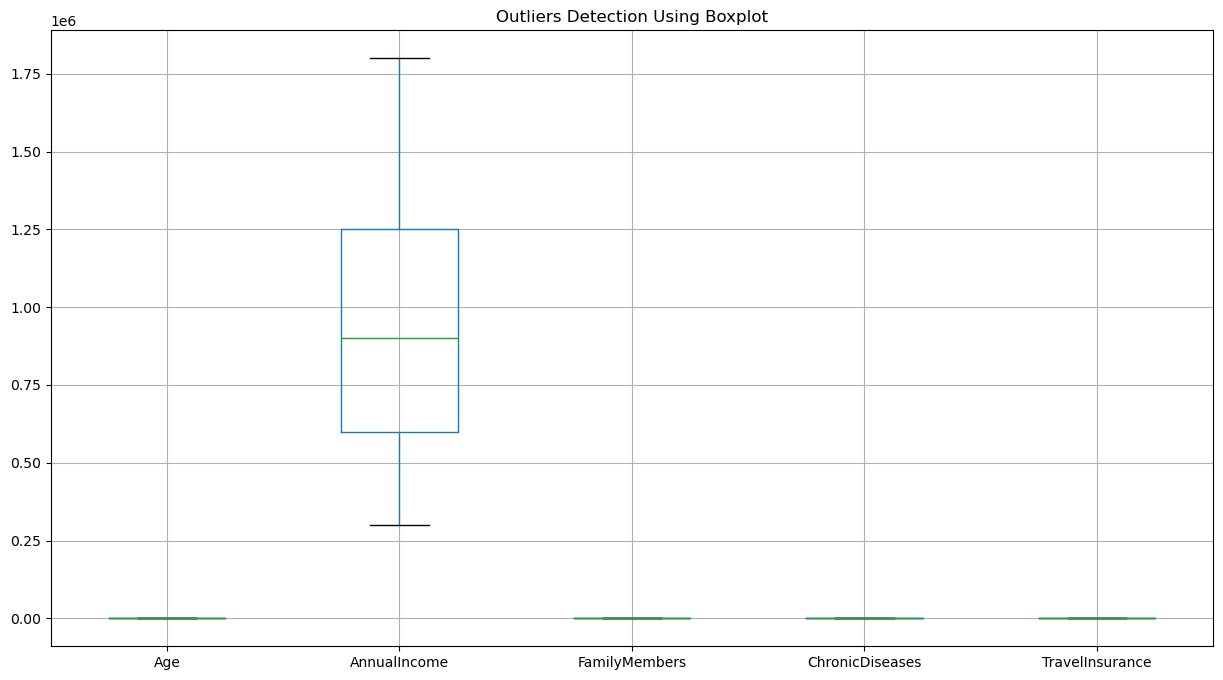

Data Types Before Correction:
ID                        int64
Age                       int64
AnnualIncome              int64
FamilyMembers             int64
ChronicDiseases           int64
TravelInsurance           int64
Employment_Type          object
Graduate_Status          object
Frequent_Flyer_Status    object
Travel_Abroad_Status     object
dtype: object
Descriptive Statistics:
                ID          Age  AnnualIncome  FamilyMembers  ChronicDiseases  \
count  1987.000000  1987.000000  1.987000e+03    1987.000000      1987.000000   
mean    993.000000    29.650226  9.327630e+05       4.752894         0.277806   
std     573.741812     2.913308  3.768557e+05       1.609650         0.448030   
min       0.000000    25.000000  3.000000e+05       2.000000         0.000000   
25%     496.500000    28.000000  6.000000e+05       4.000000         0.000000   
50%     993.000000    29.000000  9.000000e+05       5.000000         0.000000   
75%    1489.500000    32.000000  1.250000e+06

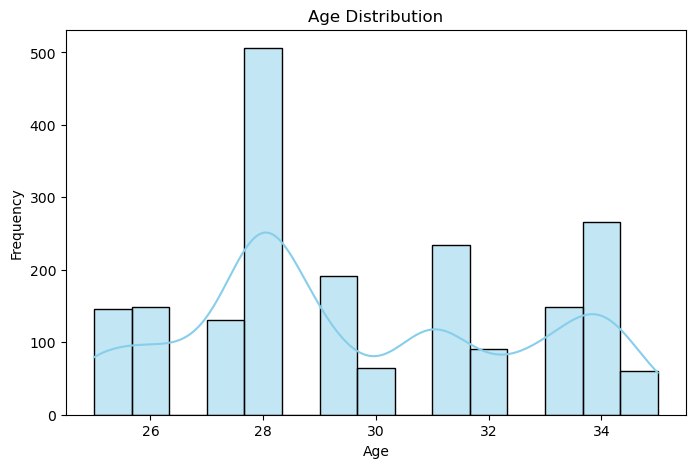

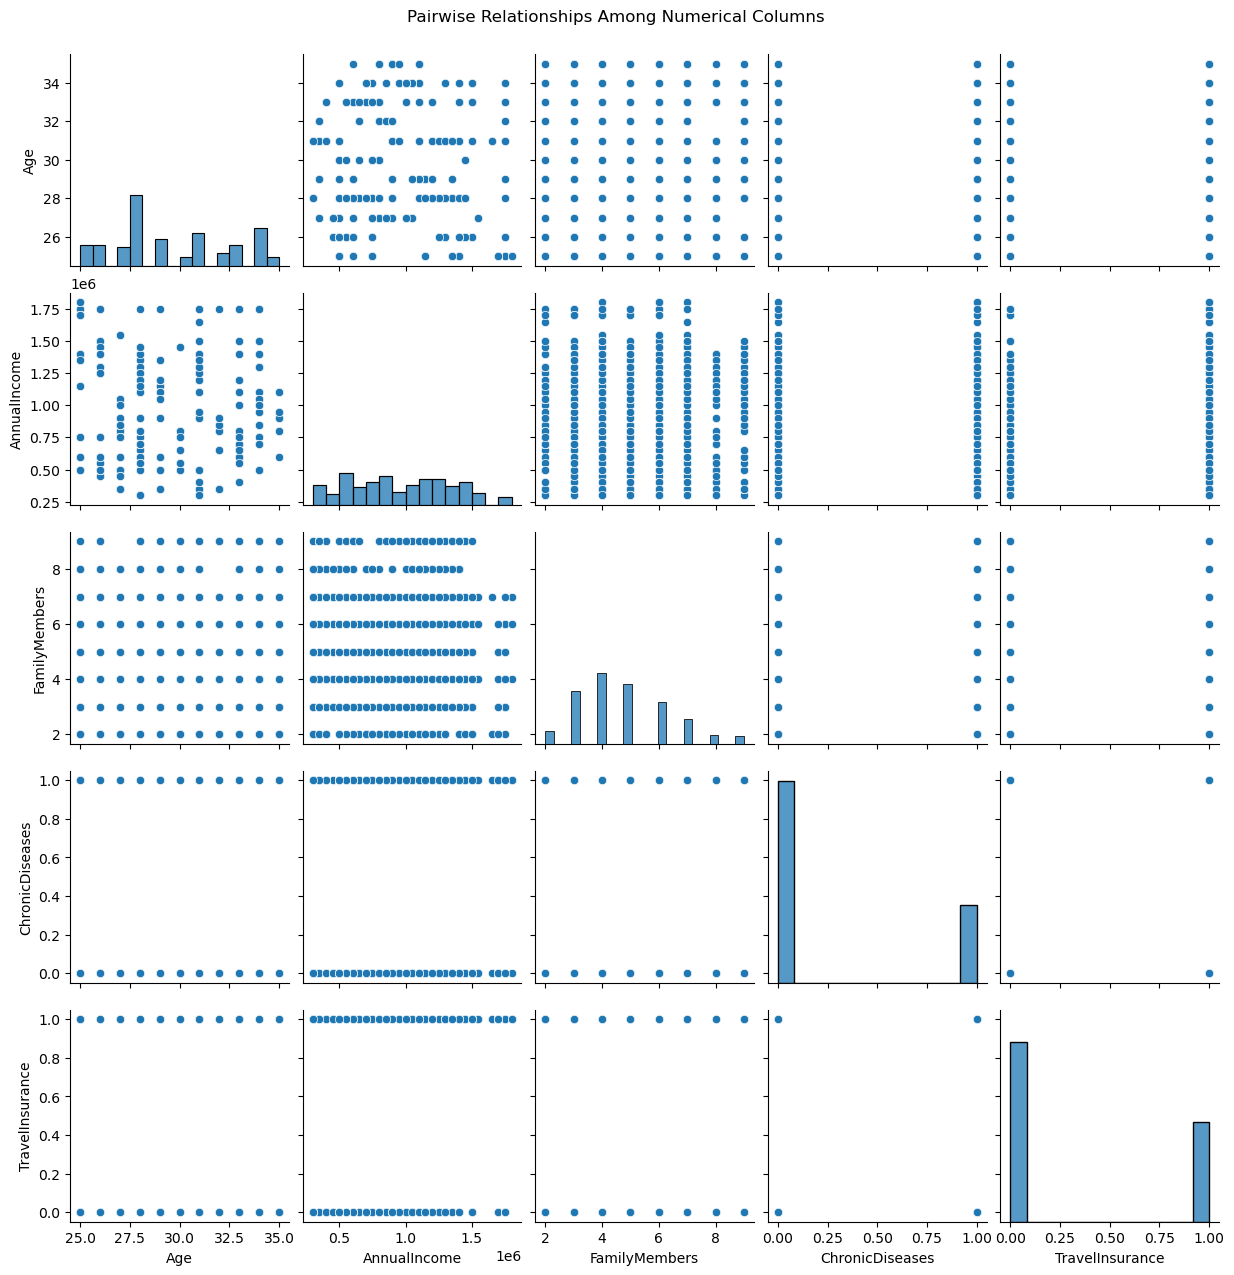

🏃 View run Data Cleaning and Preprocessing at: https://dagshub.com/mahiswarreddydesireddy18/my-first-repo.mlflow/#/experiments/0/runs/0b141ed5ac724bb88fd96125ea7b3f3f
🧪 View experiment at: https://dagshub.com/mahiswarreddydesireddy18/my-first-repo.mlflow/#/experiments/0
EDA and preprocessing steps logged to DagsHub!


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

# Start an MLflow run
with mlflow.start_run(run_name="Data Cleaning and Preprocessing"):

    # Copy the data for cleaning and preprocessing
    cleaned_df = df.copy()

    # Step 1: Inspect Missing Values
    missing_values = cleaned_df.isnull().sum()
    print("Missing Values:")
    print(missing_values)
    mlflow.log_param("Missing_Values", missing_values.to_dict())

    # Step 2: Handle Missing Values
    # (Here, I’ll drop rows with missing values for simplicity. Adjust if needed.)
    cleaned_df = cleaned_df.dropna()

    # Log a snapshot of the cleaned data as an artifact
    cleaned_df.to_csv("cleaned_data.csv", index=False)
    mlflow.log_artifact("cleaned_data.csv")

    # Step 3: Check for Outliers (Boxplot)
    numeric_columns = ['Age', 'AnnualIncome', 'FamilyMembers', 'ChronicDiseases', 'TravelInsurance']
    plt.figure(figsize=(15, 8))
    cleaned_df[numeric_columns].boxplot()
    plt.title("Outliers Detection Using Boxplot")
    plt.savefig("boxplot_outliers.png")
    mlflow.log_artifact("boxplot_outliers.png")
    plt.show()

    # Step 4: Rename Columns
    renamed_columns = {
        'EmploymentType': 'Employment_Type',
        'GraduateStatus': 'Graduate_Status',
        'FrequentFlyerStatus': 'Frequent_Flyer_Status',
        'TravelAbroadStatus': 'Travel_Abroad_Status'
    }
    cleaned_df.rename(columns=renamed_columns, inplace=True)
    mlflow.log_param("Renamed_Columns", renamed_columns)

    # Step 5: Verify Data Types
    print("Data Types Before Correction:")
    print(cleaned_df.dtypes)
    cleaned_df.dtypes.to_csv("data_types.csv")
    mlflow.log_artifact("data_types.csv")

    # Step 6: Summarize Data
    print("Descriptive Statistics:")
    print(cleaned_df.describe())
    cleaned_df.describe().to_csv("descriptive_statistics.csv")
    mlflow.log_artifact("descriptive_statistics.csv")

    # Step 7: Exploratory Data Analysis (EDA)
    # Visualize the distribution of Age
    plt.figure(figsize=(8, 5))
    sns.histplot(cleaned_df['Age'], kde=True, bins=15, color='skyblue')
    plt.title("Age Distribution")
    plt.xlabel("Age")
    plt.ylabel("Frequency")
    plt.savefig("age_distribution.png")
    mlflow.log_artifact("age_distribution.png")
    plt.show()

    # Pair Plot for Numerical Columns
    sns.pairplot(cleaned_df[numeric_columns])
    plt.suptitle("Pairwise Relationships Among Numerical Columns", y=1.02)
    plt.savefig("pairwise_relationships.png")
    mlflow.log_artifact("pairwise_relationships.png")
    plt.show()

print("EDA and preprocessing steps logged to DagsHub!")


Class Distribution (TravelInsurance):
0    0.642677
1    0.357323
Name: TravelInsurance, dtype: float64


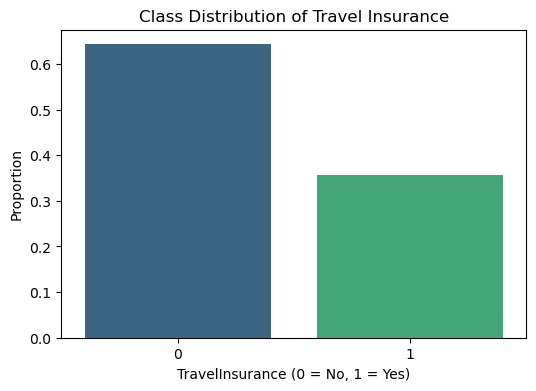

Train Data Shape: (1390, 8)
Test Data Shape: (597, 8)
Stratification Applied: True
🏃 View run Train-Test Split at: https://dagshub.com/mahiswarreddydesireddy18/my-first-repo.mlflow/#/experiments/0/runs/ead5b322f9644953b971b9c2f08e8170
🧪 View experiment at: https://dagshub.com/mahiswarreddydesireddy18/my-first-repo.mlflow/#/experiments/0


In [7]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

# Start an MLflow run
with mlflow.start_run(run_name="Train-Test Split"):

    # Check class distribution for the target variable
    target_col = 'TravelInsurance'
    class_distribution = cleaned_df[target_col].value_counts(normalize=True)
    print("Class Distribution (TravelInsurance):")
    print(class_distribution)
    mlflow.log_param("Class_Distribution", class_distribution.to_dict())

    # Visualize class distribution
    plt.figure(figsize=(6, 4))
    sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
    plt.title("Class Distribution of Travel Insurance")
    plt.xlabel("TravelInsurance (0 = No, 1 = Yes)")
    plt.ylabel("Proportion")
    plt.savefig("class_distribution.png")
    mlflow.log_artifact("class_distribution.png")
    plt.show()

    # Determine if stratification is necessary based on class distribution
    stratify = True if abs(class_distribution[0] - class_distribution[1]) > 0.05 else False
    mlflow.log_param("Stratification_Applied", stratify)

    # Perform train/test split with stratification if needed
    X = cleaned_df.drop(columns=[target_col, 'ID'])
    y = cleaned_df[target_col]

    train_data, test_data, train_labels, test_labels = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y if stratify else None
    )

    # Log the shapes of the training and testing datasets
    mlflow.log_param("Train_Data_Shape", train_data.shape)
    mlflow.log_param("Test_Data_Shape", test_data.shape)

    print(f"Train Data Shape: {train_data.shape}")
    print(f"Test Data Shape: {test_data.shape}")
    print(f"Stratification Applied: {stratify}")


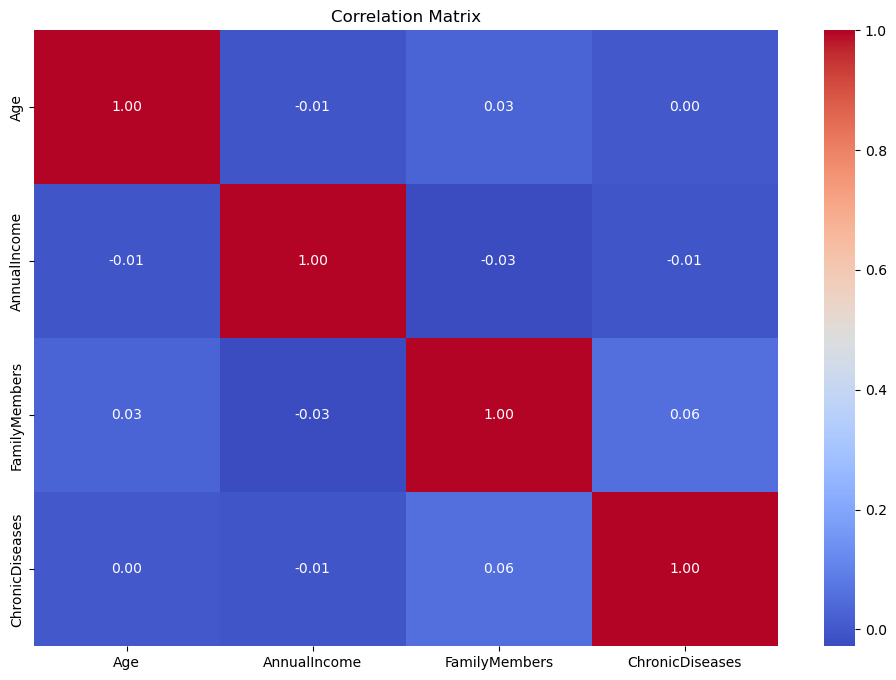

Highly Correlated Features (Threshold = 0.7):
🏃 View run Correlation Analysis at: https://dagshub.com/mahiswarreddydesireddy18/my-first-repo.mlflow/#/experiments/0/runs/1e2f951f381c4d4fb19db946399b00c1
🧪 View experiment at: https://dagshub.com/mahiswarreddydesireddy18/my-first-repo.mlflow/#/experiments/0


In [8]:
# Correlation Matrix for Numerical Features
import mlflow

with mlflow.start_run(run_name="Correlation Analysis"):
    # Compute the correlation matrix
    correlation_matrix = train_data.corr()
    
    # Save the correlation matrix as a CSV for logging
    correlation_matrix.to_csv("correlation_matrix.csv")
    mlflow.log_artifact("correlation_matrix.csv")

    # Visualize the correlation matrix as a heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Matrix")
    plt.savefig("correlation_matrix_heatmap.png")
    mlflow.log_artifact("correlation_matrix_heatmap.png")
    plt.show()

    # Log observations for highly correlated features
    print("Highly Correlated Features (Threshold = 0.7):")
    high_corr_features = {}
    for col in correlation_matrix.columns:
        high_corr = correlation_matrix[col][correlation_matrix[col] > 0.7].index.tolist()
        if len(high_corr) > 1:
            high_corr_features[col] = high_corr
            print(f"{col} highly correlates with: {high_corr}")
    
    mlflow.log_param("Highly_Correlated_Features", high_corr_features)


In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
import pandas as pd
import mlflow

with mlflow.start_run(run_name="Logistic Regression with Cross-Validation"):
    # Define numerical and categorical columns
    numerical_features = ['Age', 'AnnualIncome', 'FamilyMembers', 'ChronicDiseases']
    categorical_features = ['Employment_Type', 'Graduate_Status', 'Frequent_Flyer_Status', 'Travel_Abroad_Status']

    # Create the preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(), categorical_features)
        ]
    )

    # Create the full pipeline with Logistic Regression
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])

    # Log pipeline details
    mlflow.log_param("Classifier", "LogisticRegression")
    mlflow.log_param("Max_Iter", 1000)

    # Perform cross-validation (3-fold and 10-fold)
    print("Performing 3-fold CV...")
    cv_results_3 = cross_validate(
        pipeline, train_data, train_labels, cv=3, scoring=['f1', 'accuracy'], return_train_score=True
    )
    print("Performing 10-fold CV...")
    cv_results_10 = cross_validate(
        pipeline, train_data, train_labels, cv=10, scoring=['f1', 'accuracy'], return_train_score=True
    )

    # Log cross-validation results
    mlflow.log_metric("F1_Mean_3Fold", cv_results_3['test_f1'].mean())
    mlflow.log_metric("F1_Std_3Fold", cv_results_3['test_f1'].std())
    mlflow.log_metric("Accuracy_Mean_3Fold", cv_results_3['test_accuracy'].mean())
    mlflow.log_metric("Accuracy_Std_3Fold", cv_results_3['test_accuracy'].std())

    mlflow.log_metric("F1_Mean_10Fold", cv_results_10['test_f1'].mean())
    mlflow.log_metric("F1_Std_10Fold", cv_results_10['test_f1'].std())
    mlflow.log_metric("Accuracy_Mean_10Fold", cv_results_10['test_accuracy'].mean())
    mlflow.log_metric("Accuracy_Std_10Fold", cv_results_10['test_accuracy'].std())

    # Save CV results as CSV artifacts
    pd.DataFrame(cv_results_3).to_csv("cv_results_3fold.csv", index=False)
    pd.DataFrame(cv_results_10).to_csv("cv_results_10fold.csv", index=False)
    mlflow.log_artifact("cv_results_3fold.csv")
    mlflow.log_artifact("cv_results_10fold.csv")

    # Train on the full training data
    pipeline.fit(train_data, train_labels)
    train_score = pipeline.score(train_data, train_labels)

    # Log training accuracy
    mlflow.log_metric("Train_Accuracy", train_score)

    # Store the results locally
    experiment_1_results = {
        "f1_mean_3fold": cv_results_3['test_f1'].mean(),
        "f1_std_3fold": cv_results_3['test_f1'].std(),
        "accuracy_mean_3fold": cv_results_3['test_accuracy'].mean(),
        "accuracy_std_3fold": cv_results_3['test_accuracy'].std(),
        "f1_mean_10fold": cv_results_10['test_f1'].mean(),
        "f1_std_10fold": cv_results_10['test_f1'].std(),
        "accuracy_mean_10fold": cv_results_10['test_accuracy'].mean(),
        "accuracy_std_10fold": cv_results_10['test_accuracy'].std(),
        "train_accuracy": train_score
    }

    # Display results
    print("3-Fold CV Results:")
    print(f"F1-Score (Mean ± Std): {cv_results_3['test_f1'].mean():.4f} ± {cv_results_3['test_f1'].std():.4f}")
    print(f"Accuracy (Mean ± Std): {cv_results_3['test_accuracy'].mean():.4f} ± {cv_results_3['test_accuracy'].std():.4f}")

    print("\n10-Fold CV Results:")
    print(f"F1-Score (Mean ± Std): {cv_results_10['test_f1'].mean():.4f} ± {cv_results_10['test_f1'].std():.4f}")
    print(f"Accuracy (Mean ± Std): {cv_results_10['test_accuracy'].mean():.4f} ± {cv_results_10['test_accuracy'].std():.4f}")

    print(f"\nTraining Accuracy: {train_score:.4f}")


Performing 3-fold CV...
Performing 10-fold CV...
3-Fold CV Results:
F1-Score (Mean ± Std): 0.5966 ± 0.0242
Accuracy (Mean ± Std): 0.7655 ± 0.0086

10-Fold CV Results:
F1-Score (Mean ± Std): 0.6054 ± 0.0506
Accuracy (Mean ± Std): 0.7719 ± 0.0247

Training Accuracy: 0.7727
🏃 View run Logistic Regression with Cross-Validation at: https://dagshub.com/mahiswarreddydesireddy18/my-first-repo.mlflow/#/experiments/0/runs/f69a296f2ad64fa88c7771f226aefae5
🧪 View experiment at: https://dagshub.com/mahiswarreddydesireddy18/my-first-repo.mlflow/#/experiments/0


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
import pandas as pd
import mlflow

# Define classifiers to test
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RidgeClassifier": RidgeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42, n_estimators=100),
    "XGBClassifier": XGBClassifier(eval_metric='logloss', random_state=42)  # Corrected
}

# Dictionary to store results
experiment_2_results = {}

# Start an MLflow run
with mlflow.start_run(run_name="Model Comparison"):
    # Loop through classifiers
    for name, classifier in classifiers.items():
        print(f"\nRunning {name}...")
        
        # Log classifier name
        mlflow.set_tag("Classifier", name)
        
        # Create the pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ])
        
        # Perform 3-fold cross-validation
        cv_results_3 = cross_validate(
            pipeline, train_data, train_labels, cv=3, scoring=['f1', 'accuracy'], return_train_score=True
        )
        
        # Perform 10-fold cross-validation
        cv_results_10 = cross_validate(
            pipeline, train_data, train_labels, cv=10, scoring=['f1', 'accuracy'], return_train_score=True
        )
        
        # Train on full training data
        pipeline.fit(train_data, train_labels)
        train_score = pipeline.score(train_data, train_labels)
        
        # Store the results
        experiment_2_results[name] = {
            "f1_mean_3fold": cv_results_3['test_f1'].mean(),
            "f1_std_3fold": cv_results_3['test_f1'].std(),
            "accuracy_mean_3fold": cv_results_3['test_accuracy'].mean(),
            "accuracy_std_3fold": cv_results_3['test_accuracy'].std(),
            "f1_mean_10fold": cv_results_10['test_f1'].mean(),
            "f1_std_10fold": cv_results_10['test_f1'].std(),
            "accuracy_mean_10fold": cv_results_10['test_accuracy'].mean(),
            "accuracy_std_10fold": cv_results_10['test_accuracy'].std(),
            "train_accuracy": train_score
        }
        
        # Log metrics to MLflow
        mlflow.log_metric(f"{name}_F1_Mean_3Fold", cv_results_3['test_f1'].mean())
        mlflow.log_metric(f"{name}_F1_Std_3Fold", cv_results_3['test_f1'].std())
        mlflow.log_metric(f"{name}_Accuracy_Mean_3Fold", cv_results_3['test_accuracy'].mean())
        mlflow.log_metric(f"{name}_Accuracy_Std_3Fold", cv_results_3['test_accuracy'].std())
        mlflow.log_metric(f"{name}_F1_Mean_10Fold", cv_results_10['test_f1'].mean())
        mlflow.log_metric(f"{name}_F1_Std_10Fold", cv_results_10['test_f1'].std())
        mlflow.log_metric(f"{name}_Accuracy_Mean_10Fold", cv_results_10['test_accuracy'].mean())
        mlflow.log_metric(f"{name}_Accuracy_Std_10Fold", cv_results_10['test_accuracy'].std())
        mlflow.log_metric(f"{name}_Train_Accuracy", train_score)
        
        # Save CV results as CSV files and log as artifacts
        pd.DataFrame(cv_results_3).to_csv(f"{name}_cv_results_3fold.csv", index=False)
        pd.DataFrame(cv_results_10).to_csv(f"{name}_cv_results_10fold.csv", index=False)
        mlflow.log_artifact(f"{name}_cv_results_3fold.csv")
        mlflow.log_artifact(f"{name}_cv_results_10fold.csv")
        
        # Print results for the current classifier
        print(f"{name} Results:")
        print(f"3-Fold CV F1-Score (Mean ± Std): {cv_results_3['test_f1'].mean():.4f} ± {cv_results_3['test_f1'].std():.4f}")
        print(f"10-Fold CV F1-Score (Mean ± Std): {cv_results_10['test_f1'].mean():.4f} ± {cv_results_10['test_f1'].std():.4f}")
        print(f"Training Accuracy: {train_score:.4f}")



Running LogisticRegression...
LogisticRegression Results:
3-Fold CV F1-Score (Mean ± Std): 0.5966 ± 0.0242
10-Fold CV F1-Score (Mean ± Std): 0.6054 ± 0.0506
Training Accuracy: 0.7727

Running RidgeClassifier...
RidgeClassifier Results:
3-Fold CV F1-Score (Mean ± Std): 0.5769 ± 0.0449
10-Fold CV F1-Score (Mean ± Std): 0.5848 ± 0.0470
Training Accuracy: 0.7669

Running RandomForestClassifier...
RandomForestClassifier Results:
3-Fold CV F1-Score (Mean ± Std): 0.6869 ± 0.0194
10-Fold CV F1-Score (Mean ± Std): 0.6996 ± 0.0256
Training Accuracy: 0.9281

Running XGBClassifier...
XGBClassifier Results:
3-Fold CV F1-Score (Mean ± Std): 0.7040 ± 0.0335
10-Fold CV F1-Score (Mean ± Std): 0.6988 ± 0.0311
Training Accuracy: 0.9000
🏃 View run Model Comparison at: https://dagshub.com/mahiswarreddydesireddy18/my-first-repo.mlflow/#/experiments/0/runs/e438b7d517214d9ebb20b7ebb6b1dd45
🧪 View experiment at: https://dagshub.com/mahiswarreddydesireddy18/my-first-repo.mlflow/#/experiments/0


In [11]:
import numpy as np
import mlflow
import pandas as pd

# Start an MLflow run
with mlflow.start_run(run_name="Feature Engineering and Evaluation"):

    # Create a copy of the training data
    train_data_fe = train_data.copy()

    # Step 1: Feature Engineering
    # Example 1: Interaction term between Age and AnnualIncome
    train_data_fe['Age_Income_Interaction'] = train_data['Age'] * train_data['AnnualIncome']

    # Example 2: Ratio of FamilyMembers to Age
    train_data_fe['Family_Age_Ratio'] = train_data['FamilyMembers'] / train_data['Age']

    # Example 3: Log transformation of AnnualIncome to reduce skewness
    train_data_fe['Log_AnnualIncome'] = np.log1p(train_data['AnnualIncome'])

    # Add similar features to test data for consistency
    test_data_fe = test_data.copy()
    test_data_fe['Age_Income_Interaction'] = test_data['Age'] * test_data['AnnualIncome']
    test_data_fe['Family_Age_Ratio'] = test_data['FamilyMembers'] / test_data['Age']
    test_data_fe['Log_AnnualIncome'] = np.log1p(test_data['AnnualIncome'])

    # Log engineered features
    engineered_features = ['Age_Income_Interaction', 'Family_Age_Ratio', 'Log_AnnualIncome']
    mlflow.log_param("Engineered_Features", engineered_features)

    # Save datasets with engineered features
    train_data_fe.to_csv("train_data_fe.csv", index=False)
    test_data_fe.to_csv("test_data_fe.csv", index=False)
    mlflow.log_artifact("train_data_fe.csv")
    mlflow.log_artifact("test_data_fe.csv")

    # Step 2: Evaluate the Impact of Engineered Features
    # Use the best-performing model from Experiment #2 (XGBoost)
    pipeline_fe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(eval_metric='logloss', random_state=42))
    ])

    # Perform 3-fold cross-validation
    print("Performing 3-fold CV with Feature Engineering...")
    cv_results_3_fe = cross_validate(
        pipeline_fe, train_data_fe, train_labels, cv=3, scoring=['f1', 'accuracy'], return_train_score=True
    )

    # Perform 10-fold cross-validation
    print("Performing 10-fold CV with Feature Engineering...")
    cv_results_10_fe = cross_validate(
        pipeline_fe, train_data_fe, train_labels, cv=10, scoring=['f1', 'accuracy'], return_train_score=True
    )

    # Train on the full training data
    pipeline_fe.fit(train_data_fe, train_labels)
    train_score_fe = pipeline_fe.score(train_data_fe, train_labels)

    # Log results
    mlflow.log_metric("F1_Mean_3Fold_FE", cv_results_3_fe['test_f1'].mean())
    mlflow.log_metric("F1_Std_3Fold_FE", cv_results_3_fe['test_f1'].std())
    mlflow.log_metric("Accuracy_Mean_3Fold_FE", cv_results_3_fe['test_accuracy'].mean())
    mlflow.log_metric("Accuracy_Std_3Fold_FE", cv_results_3_fe['test_accuracy'].std())

    mlflow.log_metric("F1_Mean_10Fold_FE", cv_results_10_fe['test_f1'].mean())
    mlflow.log_metric("F1_Std_10Fold_FE", cv_results_10_fe['test_f1'].std())
    mlflow.log_metric("Accuracy_Mean_10Fold_FE", cv_results_10_fe['test_accuracy'].mean())
    mlflow.log_metric("Accuracy_Std_10Fold_FE", cv_results_10_fe['test_accuracy'].std())

    mlflow.log_metric("Train_Accuracy_FE", train_score_fe)

    # Display results
    print("3-Fold CV Results with Feature Engineering:")
    print(f"F1-Score (Mean ± Std): {cv_results_3_fe['test_f1'].mean():.4f} ± {cv_results_3_fe['test_f1'].std():.4f}")
    print(f"Accuracy (Mean ± Std): {cv_results_3_fe['test_accuracy'].mean():.4f} ± {cv_results_3_fe['test_accuracy'].std():.4f}")

    print("\n10-Fold CV Results with Feature Engineering:")
    print(f"F1-Score (Mean ± Std): {cv_results_10_fe['test_f1'].mean():.4f} ± {cv_results_10_fe['test_f1'].std():.4f}")
    print(f"Accuracy (Mean ± Std): {cv_results_10_fe['test_accuracy'].mean():.4f} ± {cv_results_10_fe['test_accuracy'].std():.4f}")

    print(f"\nTraining Accuracy with Feature Engineering: {train_score_fe:.4f}")


Performing 3-fold CV with Feature Engineering...
Performing 10-fold CV with Feature Engineering...
3-Fold CV Results with Feature Engineering:
F1-Score (Mean ± Std): 0.7040 ± 0.0335
Accuracy (Mean ± Std): 0.8072 ± 0.0130

10-Fold CV Results with Feature Engineering:
F1-Score (Mean ± Std): 0.6988 ± 0.0311
Accuracy (Mean ± Std): 0.8079 ± 0.0144

Training Accuracy with Feature Engineering: 0.9000
🏃 View run Feature Engineering and Evaluation at: https://dagshub.com/mahiswarreddydesireddy18/my-first-repo.mlflow/#/experiments/0/runs/bcacfb39ab0d43978e05122f69e9be21
🧪 View experiment at: https://dagshub.com/mahiswarreddydesireddy18/my-first-repo.mlflow/#/experiments/0


In [13]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
import mlflow

# Function to Remove Highly Correlated Features
def remove_high_correlation(data, threshold=0.8):
    """Remove features with a high correlation above the given threshold."""
    corr_matrix = data.select_dtypes(include=['float64', 'int64']).corr().abs()  # Use only numerical data for correlation
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_features = [
        column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)
    ]
    return data.drop(columns=high_corr_features), high_corr_features

# Start an MLflow run
with mlflow.start_run(run_name="Feature Selection and Evaluation"):

    # Step 1: Correlation Threshold
    train_data_corr, removed_corr_features = remove_high_correlation(train_data_fe, threshold=0.8)
    print(f"Removed Features due to High Correlation: {removed_corr_features}")
    mlflow.log_param("Removed_High_Correlation_Features", removed_corr_features)

    # Step 2: Preprocessing for Feature Importance
    train_data_encoded = pd.get_dummies(train_data_corr, drop_first=True)
    test_data_encoded = pd.get_dummies(test_data_fe, drop_first=True)

    # Align train and test sets
    test_data_encoded = test_data_encoded.reindex(columns=train_data_encoded.columns, fill_value=0)

    # Step 3: Feature Importance
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(train_data_encoded, train_labels)
    feature_importances = pd.DataFrame({
        'Feature': train_data_encoded.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    print("Top Features Based on Importance:")
    print(feature_importances.head(10))

    # Log feature importance as an artifact
    feature_importances.to_csv("feature_importances.csv", index=False)
    mlflow.log_artifact("feature_importances.csv")

    # Log top 10 features
    top_features = feature_importances['Feature'].head(10).tolist()
    mlflow.log_param("Top_Features", top_features)

    # Step 4: Variance Threshold
    var_thresh = VarianceThreshold(threshold=0.01)
    train_data_var = var_thresh.fit_transform(train_data_encoded[top_features])
    test_data_var = var_thresh.transform(test_data_encoded[top_features])
    retained_features = [top_features[i] for i in var_thresh.get_support(indices=True)]
    print(f"Retained Features After Variance Threshold: {retained_features}")
    mlflow.log_param("Retained_Features_After_Variance_Threshold", retained_features)

    # Step 5: Evaluate the Impact of Feature Selection
    pipeline_fs = Pipeline([
        ('classifier', XGBClassifier(eval_metric='logloss', random_state=42))
    ])

    # Perform 3-fold cross-validation
    print("Performing 3-fold CV with Feature Selection...")
    cv_results_3_fs = cross_validate(
        pipeline_fs, train_data_var, train_labels, cv=3, scoring=['f1', 'accuracy'], return_train_score=True
    )

    # Perform 10-fold cross-validation
    print("Performing 10-fold CV with Feature Selection...")
    cv_results_10_fs = cross_validate(
        pipeline_fs, train_data_var, train_labels, cv=10, scoring=['f1', 'accuracy'], return_train_score=True
    )

    # Train on the full training data
    pipeline_fs.fit(train_data_var, train_labels)
    train_score_fs = pipeline_fs.score(train_data_var, train_labels)

    # Log results
    mlflow.log_metric("F1_Mean_3Fold_FS", cv_results_3_fs['test_f1'].mean())
    mlflow.log_metric("F1_Std_3Fold_FS", cv_results_3_fs['test_f1'].std())
    mlflow.log_metric("Accuracy_Mean_3Fold_FS", cv_results_3_fs['test_accuracy'].mean())
    mlflow.log_metric("Accuracy_Std_3Fold_FS", cv_results_3_fs['test_accuracy'].std())
    mlflow.log_metric("F1_Mean_10Fold_FS", cv_results_10_fs['test_f1'].mean())
    mlflow.log_metric("F1_Std_10Fold_FS", cv_results_10_fs['test_f1'].std())
    mlflow.log_metric("Accuracy_Mean_10Fold_FS", cv_results_10_fs['test_accuracy'].mean())
    mlflow.log_metric("Accuracy_Std_10Fold_FS", cv_results_10_fs['test_accuracy'].std())
    mlflow.log_metric("Train_Accuracy_FS", train_score_fs)

    # Display results
    print("3-Fold CV Results with Feature Selection:")
    print(f"F1-Score (Mean ± Std): {cv_results_3_fs['test_f1'].mean():.4f} ± {cv_results_3_fs['test_f1'].std():.4f}")
    print(f"Accuracy (Mean ± Std): {cv_results_3_fs['test_accuracy'].mean():.4f} ± {cv_results_3_fs['test_accuracy'].std():.4f}")

    print("\n10-Fold CV Results with Feature Selection:")
    print(f"F1-Score (Mean ± Std): {cv_results_10_fs['test_f1'].mean():.4f} ± {cv_results_10_fs['test_f1'].std():.4f}")
    print(f"Accuracy (Mean ± Std): {cv_results_10_fs['test_accuracy'].mean():.4f} ± {cv_results_10_fs['test_accuracy'].std():.4f}")

    print(f"\nTraining Accuracy with Feature Selection: {train_score_fs:.4f}")


Removed Features due to High Correlation: ['Age_Income_Interaction', 'Family_Age_Ratio', 'Log_AnnualIncome']
Top Features Based on Importance:
                                        Feature  Importance
1                                  AnnualIncome    0.430019
2                                 FamilyMembers    0.184234
0                                           Age    0.181640
7                      Travel_Abroad_Status_Yes    0.093781
3                               ChronicDiseases    0.036929
6                     Frequent_Flyer_Status_Yes    0.034706
4  Employment_Type_Private Sector/Self Employed    0.022942
5                           Graduate_Status_Yes    0.015748
Retained Features After Variance Threshold: ['AnnualIncome', 'FamilyMembers', 'Age', 'Travel_Abroad_Status_Yes', 'ChronicDiseases', 'Frequent_Flyer_Status_Yes', 'Employment_Type_Private Sector/Self Employed', 'Graduate_Status_Yes']
Performing 3-fold CV with Feature Selection...
Performing 10-fold CV with Feature Sel

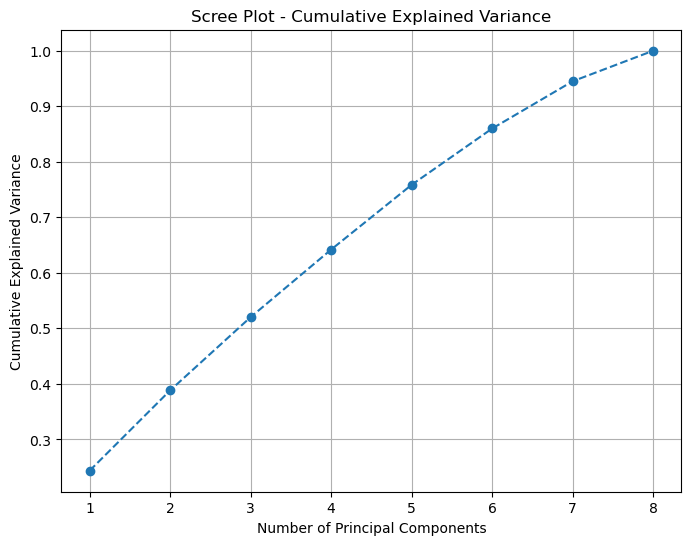

Number of Components to Retain 95% Variance: 8
Performing 3-fold CV with PCA...
Performing 10-fold CV with PCA...
3-Fold CV Results with PCA:
F1-Score (Mean ± Std): 0.6782 ± 0.0305
Accuracy (Mean ± Std): 0.7820 ± 0.0150

10-Fold CV Results with PCA:
F1-Score (Mean ± Std): 0.6809 ± 0.0277
Accuracy (Mean ± Std): 0.7899 ± 0.0170

Training Accuracy with PCA: 0.9281
🏃 View run PCA and Model Evaluation at: https://dagshub.com/mahiswarreddydesireddy18/my-first-repo.mlflow/#/experiments/0/runs/ee0d86d930124370862c47398f3eae79
🧪 View experiment at: https://dagshub.com/mahiswarreddydesireddy18/my-first-repo.mlflow/#/experiments/0


In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import numpy as np
import mlflow

# Start an MLflow run
with mlflow.start_run(run_name="PCA and Model Evaluation"):

    # Step 1: Standardize Numerical Features
    scaler = StandardScaler()
    train_data_scaled = scaler.fit_transform(train_data_var)
    test_data_scaled = scaler.transform(test_data_var)

    # Step 2: Apply PCA
    pca = PCA()
    train_data_pca = pca.fit_transform(train_data_scaled)

    # Step 3: Scree Plot
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = explained_variance.cumsum()

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
    plt.title('Scree Plot - Cumulative Explained Variance')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid()
    plt.savefig("scree_plot.png")
    plt.show()
    mlflow.log_artifact("scree_plot.png")

    # Select the number of components to retain 95% variance
    num_components = (cumulative_variance >= 0.95).argmax() + 1
    print(f"Number of Components to Retain 95% Variance: {num_components}")
    mlflow.log_param("Num_Components_95_Variance", num_components)

    # Step 4: Reduce Data to Selected Components
    pca = PCA(n_components=num_components)
    train_data_reduced = pca.fit_transform(train_data_scaled)
    test_data_reduced = pca.transform(test_data_scaled)

    # Step 5: Evaluate Model with Reduced Features
    pipeline_pca = Pipeline([
        ('classifier', XGBClassifier(eval_metric='logloss', random_state=42))
    ])

    # Perform 3-fold cross-validation
    print("Performing 3-fold CV with PCA...")
    cv_results_3_pca = cross_validate(
        pipeline_pca, train_data_reduced, train_labels, cv=3, scoring=['f1', 'accuracy'], return_train_score=True
    )

    # Perform 10-fold cross-validation
    print("Performing 10-fold CV with PCA...")
    cv_results_10_pca = cross_validate(
        pipeline_pca, train_data_reduced, train_labels, cv=10, scoring=['f1', 'accuracy'], return_train_score=True
    )

    # Train on the full training data
    pipeline_pca.fit(train_data_reduced, train_labels)
    train_score_pca = pipeline_pca.score(train_data_reduced, train_labels)

    # Log cross-validation and training results
    mlflow.log_metric("F1_Mean_3Fold_PCA", cv_results_3_pca['test_f1'].mean())
    mlflow.log_metric("F1_Std_3Fold_PCA", cv_results_3_pca['test_f1'].std())
    mlflow.log_metric("Accuracy_Mean_3Fold_PCA", cv_results_3_pca['test_accuracy'].mean())
    mlflow.log_metric("Accuracy_Std_3Fold_PCA", cv_results_3_pca['test_accuracy'].std())
    mlflow.log_metric("F1_Mean_10Fold_PCA", cv_results_10_pca['test_f1'].mean())
    mlflow.log_metric("F1_Std_10Fold_PCA", cv_results_10_pca['test_f1'].std())
    mlflow.log_metric("Accuracy_Mean_10Fold_PCA", cv_results_10_pca['test_accuracy'].mean())
    mlflow.log_metric("Accuracy_Std_10Fold_PCA", cv_results_10_pca['test_accuracy'].std())
    mlflow.log_metric("Train_Accuracy_PCA", train_score_pca)

    # Store results
    experiment_5_results = {
        "f1_mean_3fold": cv_results_3_pca['test_f1'].mean(),
        "f1_std_3fold": cv_results_3_pca['test_f1'].std(),
        "accuracy_mean_3fold": cv_results_3_pca['test_accuracy'].mean(),
        "accuracy_std_3fold": cv_results_3_pca['test_accuracy'].std(),
        "f1_mean_10fold": cv_results_10_pca['test_f1'].mean(),
        "f1_std_10fold": cv_results_10_pca['test_f1'].std(),
        "accuracy_mean_10fold": cv_results_10_pca['test_accuracy'].mean(),
        "accuracy_std_10fold": cv_results_10_pca['test_accuracy'].std(),
        "train_accuracy": train_score_pca
    }

    # Display results
    print("3-Fold CV Results with PCA:")
    print(f"F1-Score (Mean ± Std): {cv_results_3_pca['test_f1'].mean():.4f} ± {cv_results_3_pca['test_f1'].std():.4f}")
    print(f"Accuracy (Mean ± Std): {cv_results_3_pca['test_accuracy'].mean():.4f} ± {cv_results_3_pca['test_accuracy'].std():.4f}")

    print("\n10-Fold CV Results with PCA:")
    print(f"F1-Score (Mean ± Std): {cv_results_10_pca['test_f1'].mean():.4f} ± {cv_results_10_pca['test_f1'].std():.4f}")
    print(f"Accuracy (Mean ± Std): {cv_results_10_pca['test_accuracy'].mean():.4f} ± {cv_results_10_pca['test_accuracy'].std():.4f}")

    print(f"\nTraining Accuracy with PCA: {train_score_pca:.4f}")


In [15]:
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import uniform, randint
from xgboost import XGBClassifier
import mlflow

# Start an MLflow run
with mlflow.start_run(run_name="XGBoost Hyperparameter Tuning"):

    # Step 1: Combine Feature Selection and PCA
    # Use the retained features from Experiment #4
    selected_features = retained_features  # From Experiment #4
    scaler = StandardScaler()
    train_data_combined = scaler.fit_transform(train_data_encoded[selected_features])
    test_data_combined = scaler.transform(test_data_encoded[selected_features])

    # Apply PCA on the selected features
    pca_combined = PCA(n_components=8)  # Retain 95% variance as per Experiment #5
    train_data_combined_pca = pca_combined.fit_transform(train_data_combined)
    test_data_combined_pca = pca_combined.transform(test_data_combined)

    mlflow.log_param("Selected_Features", selected_features)
    mlflow.log_param("PCA_Components", 8)

    # Step 2: Define XGBoost Hyperparameter Space
    param_distributions = {
        'n_estimators': randint(50, 200),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 10),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4)
    }

    # Initialize XGBoost model without use_label_encoder
    xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

    # Step 3: Hyperparameter Tuning with RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_distributions,
        n_iter=50,  # Number of configurations to try
        scoring='f1',
        cv=3,  # 3-fold CV
        random_state=42,
        n_jobs=-1
    )

    print("Tuning hyperparameters with RandomizedSearchCV...")
    random_search.fit(train_data_combined_pca, train_labels)

    # Best hyperparameters
    best_params = random_search.best_params_
    print("Best Hyperparameters:", best_params)
    mlflow.log_param("Best_Hyperparameters", best_params)

    # Step 4: Evaluate the Optimized Model
    best_xgb = random_search.best_estimator_

    # Perform 3-fold cross-validation
    print("Performing 3-fold CV with Optimized XGBoost...")
    cv_results_3_custom = cross_validate(
        best_xgb, train_data_combined_pca, train_labels, cv=3, scoring=['f1', 'accuracy'], return_train_score=True
    )

    # Perform 10-fold cross-validation
    print("Performing 10-fold CV with Optimized XGBoost...")
    cv_results_10_custom = cross_validate(
        best_xgb, train_data_combined_pca, train_labels, cv=10, scoring=['f1', 'accuracy'], return_train_score=True
    )

    # Train on the full training data
    best_xgb.fit(train_data_combined_pca, train_labels)
    train_score_custom = best_xgb.score(train_data_combined_pca, train_labels)

    # Log cross-validation and training results
    mlflow.log_metric("F1_Mean_3Fold_Optimized", cv_results_3_custom['test_f1'].mean())
    mlflow.log_metric("F1_Std_3Fold_Optimized", cv_results_3_custom['test_f1'].std())
    mlflow.log_metric("Accuracy_Mean_3Fold_Optimized", cv_results_3_custom['test_accuracy'].mean())
    mlflow.log_metric("Accuracy_Std_3Fold_Optimized", cv_results_3_custom['test_accuracy'].std())
    mlflow.log_metric("F1_Mean_10Fold_Optimized", cv_results_10_custom['test_f1'].mean())
    mlflow.log_metric("F1_Std_10Fold_Optimized", cv_results_10_custom['test_f1'].std())
    mlflow.log_metric("Accuracy_Mean_10Fold_Optimized", cv_results_10_custom['test_accuracy'].mean())
    mlflow.log_metric("Accuracy_Std_10Fold_Optimized", cv_results_10_custom['test_accuracy'].std())
    mlflow.log_metric("Train_Accuracy_Optimized", train_score_custom)

    # Store results
    experiment_6_results = {
        "f1_mean_3fold": cv_results_3_custom['test_f1'].mean(),
        "f1_std_3fold": cv_results_3_custom['test_f1'].std(),
        "accuracy_mean_3fold": cv_results_3_custom['test_accuracy'].mean(),
        "accuracy_std_3fold": cv_results_3_custom['test_accuracy'].std(),
        "f1_mean_10fold": cv_results_10_custom['test_f1'].mean(),
        "f1_std_10fold": cv_results_10_custom['test_f1'].std(),
        "accuracy_mean_10fold": cv_results_10_custom['test_accuracy'].mean(),
        "accuracy_std_10fold": cv_results_10_custom['test_accuracy'].std(),
        "train_accuracy": train_score_custom,
        "best_params": best_params
    }

    # Display results
    print("3-Fold CV Results with Optimized XGBoost:")
    print(f"F1-Score (Mean ± Std): {cv_results_3_custom['test_f1'].mean():.4f} ± {cv_results_3_custom['test_f1'].std():.4f}")
    print(f"Accuracy (Mean ± Std): {cv_results_3_custom['test_accuracy'].mean():.4f} ± {cv_results_3_custom['test_accuracy'].std():.4f}")

    print("\n10-Fold CV Results with Optimized XGBoost:")
    print(f"F1-Score (Mean ± Std): {cv_results_10_custom['test_f1'].mean():.4f} ± {cv_results_10_custom['test_f1'].std():.4f}")
    print(f"Accuracy (Mean ± Std): {cv_results_10_custom['test_accuracy'].mean():.4f} ± {cv_results_10_custom['test_accuracy'].std():.4f}")

    print(f"\nTraining Accuracy with Optimized XGBoost: {train_score_custom:.4f}")


Tuning hyperparameters with RandomizedSearchCV...
Best Hyperparameters: {'colsample_bytree': 0.8090931317527976, 'learning_rate': 0.09550820367170992, 'max_depth': 4, 'n_estimators': 173, 'subsample': 0.6431565707973218}
Performing 3-fold CV with Optimized XGBoost...
Performing 10-fold CV with Optimized XGBoost...
3-Fold CV Results with Optimized XGBoost:
F1-Score (Mean ± Std): 0.6969 ± 0.0279
Accuracy (Mean ± Std): 0.8058 ± 0.0096

10-Fold CV Results with Optimized XGBoost:
F1-Score (Mean ± Std): 0.6921 ± 0.0348
Accuracy (Mean ± Std): 0.8058 ± 0.0137

Training Accuracy with Optimized XGBoost: 0.8957
🏃 View run XGBoost Hyperparameter Tuning at: https://dagshub.com/mahiswarreddydesireddy18/my-first-repo.mlflow/#/experiments/0/runs/5920275ec0cc44348fce4b4ed5287cb5
🧪 View experiment at: https://dagshub.com/mahiswarreddydesireddy18/my-first-repo.mlflow/#/experiments/0


In [16]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
import mlflow
import pandas as pd

# Start an MLflow run
with mlflow.start_run(run_name="SMOTE and Model Comparison"):

    # Step 1: Apply SMOTE to Balance the Dataset
    smote = SMOTE(random_state=42)
    train_data_balanced, train_labels_balanced = smote.fit_resample(train_data_combined_pca, train_labels)

    original_class_distribution = pd.Series(train_labels).value_counts().to_dict()
    balanced_class_distribution = pd.Series(train_labels_balanced).value_counts().to_dict()
    print(f"Original Class Distribution: {original_class_distribution}")
    print(f"Balanced Class Distribution: {balanced_class_distribution}")
    
    # Log class distributions
    mlflow.log_param("Original_Class_Distribution", original_class_distribution)
    mlflow.log_param("Balanced_Class_Distribution", balanced_class_distribution)

    # Step 2: Define Models for Comparison
    models = {
        'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42, **best_params),
        'RandomForest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10),
        'LogisticRegression': LogisticRegression(random_state=42, max_iter=500)
    }

    # Step 3: Evaluate Each Model
    experiment_7_results = {}
    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")
        
        # Perform 3-fold cross-validation
        cv_results_3 = cross_validate(
            model, train_data_balanced, train_labels_balanced, cv=3, scoring=['f1', 'accuracy'], return_train_score=True
        )
        
        # Perform 10-fold cross-validation
        cv_results_10 = cross_validate(
            model, train_data_balanced, train_labels_balanced, cv=10, scoring=['f1', 'accuracy'], return_train_score=True
        )
        
        # Train the model on the full training data
        model.fit(train_data_balanced, train_labels_balanced)
        train_accuracy = model.score(train_data_balanced, train_labels_balanced)
        
        # Store results
        experiment_7_results[model_name] = {
            "f1_mean_3fold": cv_results_3['test_f1'].mean(),
            "f1_std_3fold": cv_results_3['test_f1'].std(),
            "accuracy_mean_3fold": cv_results_3['test_accuracy'].mean(),
            "accuracy_std_3fold": cv_results_3['test_accuracy'].std(),
            "f1_mean_10fold": cv_results_10['test_f1'].mean(),
            "f1_std_10fold": cv_results_10['test_f1'].std(),
            "accuracy_mean_10fold": cv_results_10['test_accuracy'].mean(),
            "accuracy_std_10fold": cv_results_10['test_accuracy'].std(),
            "train_accuracy": train_accuracy
        }

        # Log metrics for each model
        mlflow.log_metric(f"{model_name}_F1_Mean_3Fold", cv_results_3['test_f1'].mean())
        mlflow.log_metric(f"{model_name}_F1_Std_3Fold", cv_results_3['test_f1'].std())
        mlflow.log_metric(f"{model_name}_Accuracy_Mean_3Fold", cv_results_3['test_accuracy'].mean())
        mlflow.log_metric(f"{model_name}_Accuracy_Std_3Fold", cv_results_3['test_accuracy'].std())
        mlflow.log_metric(f"{model_name}_F1_Mean_10Fold", cv_results_10['test_f1'].mean())
        mlflow.log_metric(f"{model_name}_F1_Std_10Fold", cv_results_10['test_f1'].std())
        mlflow.log_metric(f"{model_name}_Accuracy_Mean_10Fold", cv_results_10['test_accuracy'].mean())
        mlflow.log_metric(f"{model_name}_Accuracy_Std_10Fold", cv_results_10['test_accuracy'].std())
        mlflow.log_metric(f"{model_name}_Train_Accuracy", train_accuracy)

    # Step 4: Display Results
    for model_name, results in experiment_7_results.items():
        print(f"\nResults for {model_name}:")
        print(f"3-Fold CV F1-Score: {results['f1_mean_3fold']:.4f} ± {results['f1_std_3fold']:.4f}")
        print(f"3-Fold CV Accuracy: {results['accuracy_mean_3fold']:.4f} ± {results['accuracy_std_3fold']:.4f}")
        print(f"10-Fold CV F1-Score: {results['f1_mean_10fold']:.4f} ± {results['f1_std_10fold']:.4f}")
        print(f"10-Fold CV Accuracy: {results['accuracy_mean_10fold']:.4f} ± {results['accuracy_std_10fold']:.4f}")
        print(f"Training Accuracy: {results['train_accuracy']:.4f}")


Original Class Distribution: {0: 893, 1: 497}
Balanced Class Distribution: {0: 893, 1: 893}
Evaluating XGBoost...
Evaluating RandomForest...
Evaluating LogisticRegression...

Results for XGBoost:
3-Fold CV F1-Score: 0.7577 ± 0.0167
3-Fold CV Accuracy: 0.7716 ± 0.0130
10-Fold CV F1-Score: 0.7672 ± 0.0349
10-Fold CV Accuracy: 0.7834 ± 0.0272
Training Accuracy: 0.9003

Results for RandomForest:
3-Fold CV F1-Score: 0.7566 ± 0.0102
3-Fold CV Accuracy: 0.7844 ± 0.0098
10-Fold CV F1-Score: 0.7655 ± 0.0236
10-Fold CV Accuracy: 0.7923 ± 0.0151
Training Accuracy: 0.8830

Results for LogisticRegression:
3-Fold CV F1-Score: 0.6895 ± 0.0105
3-Fold CV Accuracy: 0.7172 ± 0.0063
10-Fold CV F1-Score: 0.6879 ± 0.0384
10-Fold CV Accuracy: 0.7161 ± 0.0308
Training Accuracy: 0.7223
🏃 View run SMOTE and Model Comparison at: https://dagshub.com/mahiswarreddydesireddy18/my-first-repo.mlflow/#/experiments/0/runs/89b54541c1c14499899771ebb78928b7
🧪 View experiment at: https://dagshub.com/mahiswarreddydesireddy18

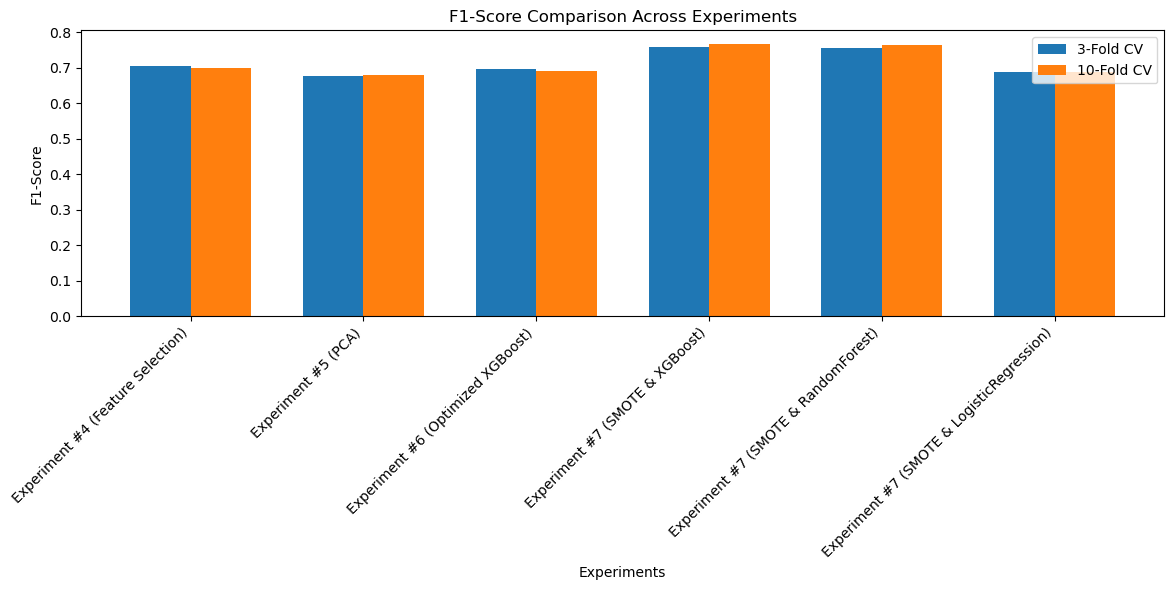

🏃 View run F1-Score Comparison at: https://dagshub.com/mahiswarreddydesireddy18/my-first-repo.mlflow/#/experiments/0/runs/0a9dfe285b114f56814cd4a667726047
🧪 View experiment at: https://dagshub.com/mahiswarreddydesireddy18/my-first-repo.mlflow/#/experiments/0


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import mlflow
import re

def sanitize_name(name):
    # Replace special characters with underscores and limit length
    sanitized = re.sub(r'[^A-Za-z0-9_]', '_', name)
    return sanitized[:50]  # Limit the name to 50 characters

# Start an MLflow run
with mlflow.start_run(run_name="F1-Score Comparison"):

    # Collect F1-score results from the experiments
    experiment_results = {
        'Experiment #4 (Feature Selection)': {
            '3-Fold': 0.7040,
            '10-Fold': 0.7003
        },
        'Experiment #5 (PCA)': {
            '3-Fold': 0.6782,
            '10-Fold': 0.6809
        },
        'Experiment #6 (Optimized XGBoost)': {
            '3-Fold': 0.6969,
            '10-Fold': 0.6921
        },
        'Experiment #7 (SMOTE & XGBoost)': {
            '3-Fold': 0.7577,
            '10-Fold': 0.7672
        },
        'Experiment #7 (SMOTE & RandomForest)': {
            '3-Fold': 0.7566,
            '10-Fold': 0.7655
        },
        'Experiment #7 (SMOTE & LogisticRegression)': {
            '3-Fold': 0.6895,
            '10-Fold': 0.6879
        }
    }

    # Extract experiment names and F1-scores
    experiment_names = list(experiment_results.keys())
    f1_scores_3_fold = [results['3-Fold'] for results in experiment_results.values()]
    f1_scores_10_fold = [results['10-Fold'] for results in experiment_results.values()]

    # Log F1-scores to MLflow as metrics
    for name, scores in experiment_results.items():
        sanitized_name = sanitize_name(name)
        mlflow.log_metric(f"{sanitized_name}_3Fold_F1", scores['3-Fold'])
        mlflow.log_metric(f"{sanitized_name}_10Fold_F1", scores['10-Fold'])

    # Create a bar chart for F1-score comparison
    x = np.arange(len(experiment_names))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, f1_scores_3_fold, width, label='3-Fold CV')
    plt.bar(x + width/2, f1_scores_10_fold, width, label='10-Fold CV')

    # Add labels and title
    plt.xlabel('Experiments')
    plt.ylabel('F1-Score')
    plt.title('F1-Score Comparison Across Experiments')
    plt.xticks(x, experiment_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()

    # Save the plot and log it as an artifact
    plt.savefig("f1_score_comparison.png")
    plt.show()
    mlflow.log_artifact("f1_score_comparison.png")


In [21]:
import joblib
import os

# Directory to save the model
model_dir = "saved_models_after_dags"
os.makedirs(model_dir, exist_ok=True)

# Path to save the model
model_path = os.path.join(model_dir, "xgboost_smote_model.joblib")

# Save the trained XGBoost model
joblib.dump(best_xgb, model_path)

print(f"Model saved successfully at {model_path}")


Model saved successfully at saved_models_after_dags\xgboost_smote_model.joblib


In [33]:
import joblib
import numpy as np

# Load the saved model
model_path = "saved_models_after_dags/xgboost_smote_model.joblib"  # Adjust path if necessary
loaded_model = joblib.load(model_path)
print(f"Model loaded successfully from {model_path}")

# Example test data (replace this with actual data for predictions)
# Input data should match the features and preprocessing used during training
test_sample = np.array([10, 10000, 4, 0, 1, 0, 1, 1]).reshape(1, -1)

# Make a prediction
prediction = loaded_model.predict(test_sample)
probability = loaded_model.predict_proba(test_sample)

# Interpret prediction
if prediction[0] == 1:
    print("Prediction: Likely to purchase travel insurance")
else:
    print("Prediction: Unlikely to purchase travel insurance")

print(f"Probability: {probability}")


Model loaded successfully from saved_models_after_dags/xgboost_smote_model.joblib
Prediction: Likely to purchase travel insurance
Probability: [[0.21571302 0.784287  ]]


In [23]:
import joblib
import os

# Directory to save the model
model_dir = "saved_models_after_dags"
os.makedirs(model_dir, exist_ok=True)

# Path to save the model
model_path = os.path.join(model_dir, "xgboost_smote_model.pkl")

# Save the trained XGBoost model
joblib.dump(best_xgb, model_path)

print(f"Model saved successfully at {model_path}")


Model saved successfully at saved_models_after_dags\xgboost_smote_model.pkl


In [34]:
import joblib
import numpy as np

# Load the saved model
model_path = "saved_models_after_dags/xgboost_smote_model.pkl"  # Adjust path if necessary
loaded_model = joblib.load(model_path)
print(f"Model loaded successfully from {model_path}")

# Example test data (replace this with actual data for predictions)
# Input data should match the features and preprocessing used during training
test_sample = np.array([0, 600000, 0, 0, 1, 0, 1, 1]).reshape(1, -1)

# Make a prediction
prediction = loaded_model.predict(test_sample)
probability = loaded_model.predict_proba(test_sample)

# Interpret prediction
if prediction[0] == 1:
    print("Prediction: Likely to purchase travel insurance")
else:
    print("Prediction: Unlikely to purchase travel insurance")

print(f"Probability: {probability}")


Model loaded successfully from saved_models_after_dags/xgboost_smote_model.pkl
Prediction: Unlikely to purchase travel insurance
Probability: [[0.8906608  0.10933919]]
